In [344]:
import re
import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

In [331]:
rcParams['figure.figsize'] = (15, 10)
sns.set(font_scale=1.5)

In [332]:
com_df = pd.read_csv('../data/comments_info.csv')
tweet_df = pd.read_csv('../data/tweets_info.csv')

cols_to_datetime = ['tweet_created', 'account_created']
df = pd.concat([tweet_df, com_df], axis=0)

### Text Exploration

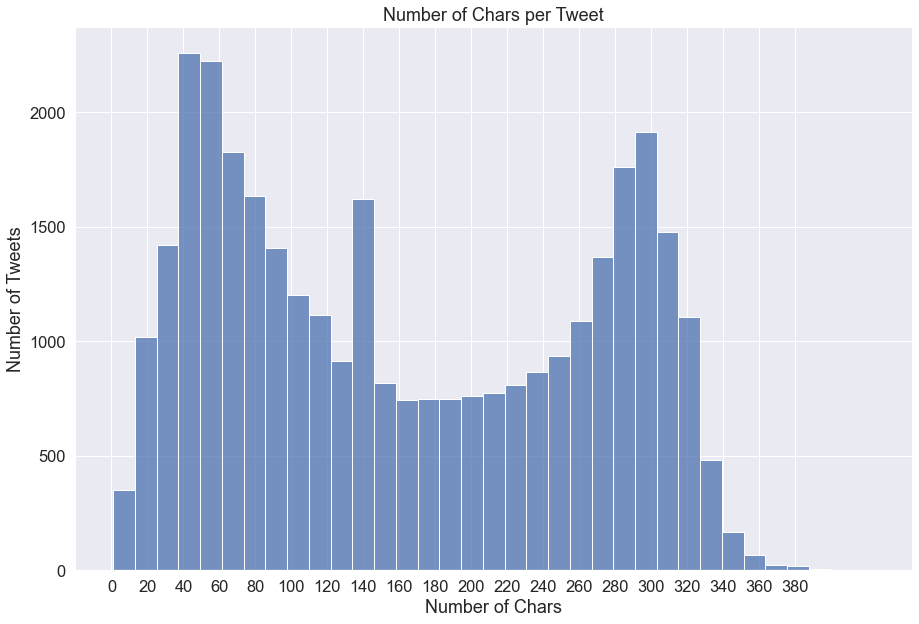

In [333]:
# let's look at the number of characters per tweet
sns.histplot(df['text'].str.len())
plt.xticks(list(range(0, 400, 20)))
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Twitter allows max 280 characters per tweets, so all the tweets with more than 280 char must contain either a lot of mentions (@someone) or links. We can also observe large amount of tweets with low number of chars. This might be caused either by stopwords, slang or something else, they might not hold a lot of meaning.
##### TODO
1. Remove Mentions (e.g. @coinbase)
2. Check the tweets with low number of chars.

In [334]:
# let's look at the actual test and see what makes tweets surpass 280 mark
df[df['text'].str.len() > 320].text.values[0]

'@saylor @MicroStrategy Navigate the market with a FREE 30 Day Trial of Bitcoin Magazine PRO, our premium markets newsletter! \n\nReceive expert analysis of:\n🌐 Global macro conditions\n⛓️ On-chain data and cyclical indicators\n🌋 Bitcoin miner economics + more\n\nSubscribe today! 📩👇\nhttps://t.co/cdhsvAKKzU https://t.co/Ucoh3HwXIY'

In [335]:
# let's remove mentions, so we can see the actual text of the tweet, and look at the graph again
df['text'].replace("@[^\s]+", '', regex=True, inplace=True)
df['text'].replace(r'http\S+', '', regex=True, inplace=True)  # removing links
df['text'].replace(r'&[A-Za-z0-9#]+;', '', regex=True, inplace=True) # removing html character reference
df['text'].replace(r"\s+", " ", regex=True, inplace=True) # remove extra space, new lines ...
df['text'].replace(r'\u200d', '', regex=True, inplace=True) # catching \u200d (width joiner) used for emojis

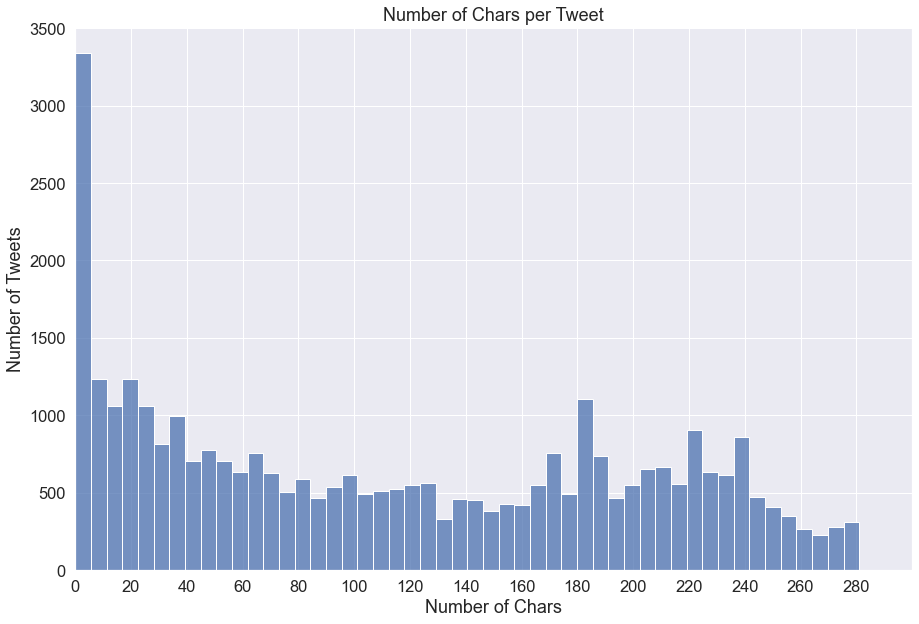

In [336]:
sns.histplot(df['text'].str.len(), bins=50)
plt.xticks(list(range(0, 290, 20)))
plt.xlim(0, 300)
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Now we see that all the tweets fall within the limit of 280 chars, but the number of tweets with less than 20 chars has increased drastically.

In [337]:
# lets see what we can fit in within 20 chars
sample_text = 'Market is going to crash'
print(f'Length of this text "{sample_text}" is {len(sample_text)} chars.')

Length of this text "Market is going to crash" is 24 chars.


###### I would think that tweets that have less than 15-20 chars are meaningless. Let's explore what kind of tweets have a few characters

In [339]:
# first let's check if we have empty strings and get rid of them
print('Number of empty string',len(df[df['text'].isin(['', ' '])].text))
df = df[~df['text'].isin(['', ' '])]

Number of empty string 2010


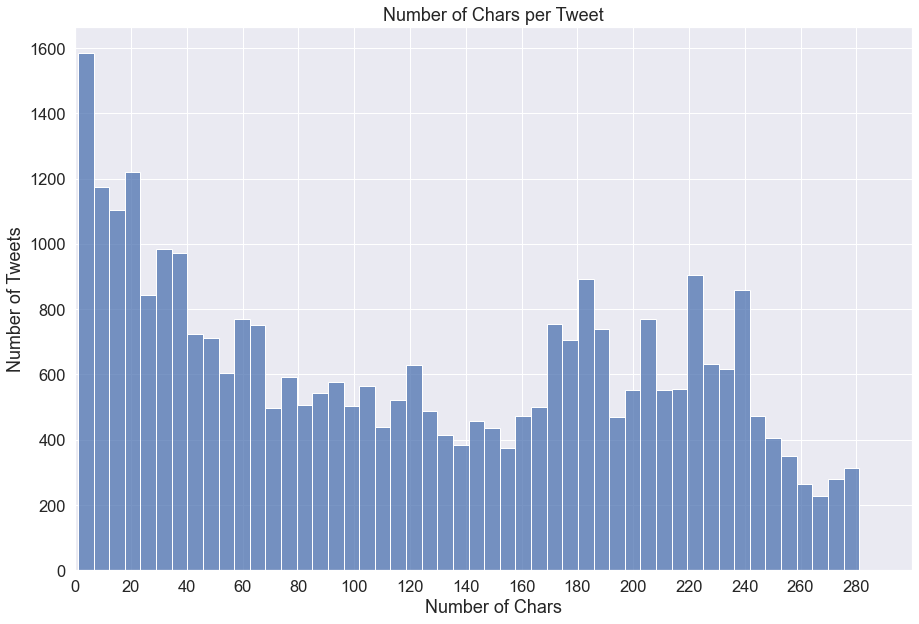

In [340]:
sns.histplot(df['text'].str.len(), bins=50)
plt.xticks(list(range(0, 290, 20)))
plt.xlim(0, 300)
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Great, we cut the number of tweets with less than 20 by a third. Although, we have to keep in mind that a lot of tweets that we get are empty, and we might have to extract more information. Let's continue to explore tweets with low number of words.

In [343]:
# let's get rid
df[df.text.str.len() < 20].text

69                       RT 
92                        👀 
208                      RT 
356                      RT 
397      They never learn 🤣 
                ...         
28917              WaaZuUpp 
28924                woww🎉👌👌
28931     hihihihihiádasdasd
28950                      😍
28959          #SpamReported
Name: text, Length: 4269, dtype: object

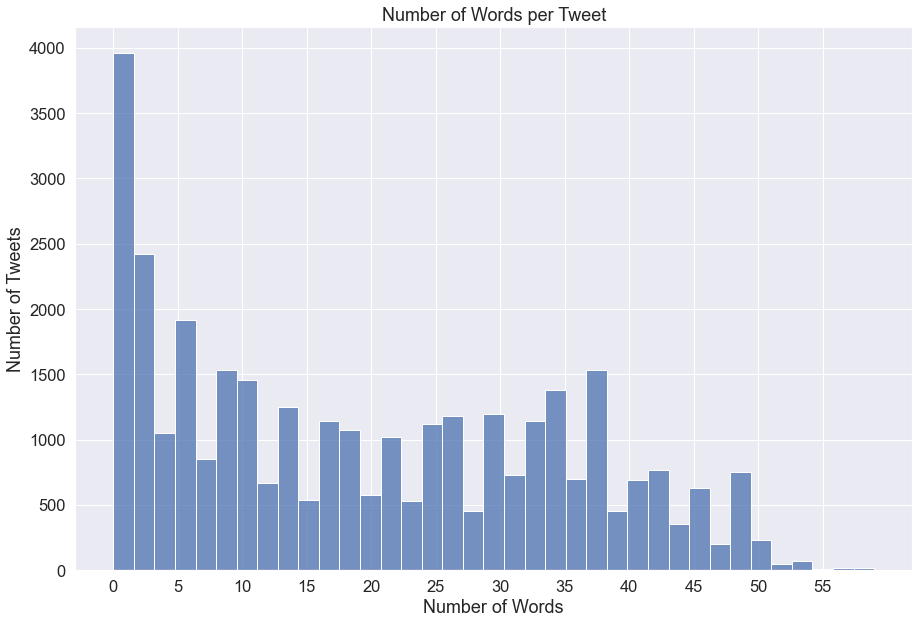

In [268]:
# let's look at the number of words per tweet
sns.histplot(df.text.str.split().map(lambda words: len(words)))
plt.xticks(list(range(0, 60, 5)))
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.title('Number of Words per Tweet');

###### Once again we can observe high amount of tweets with low word count.

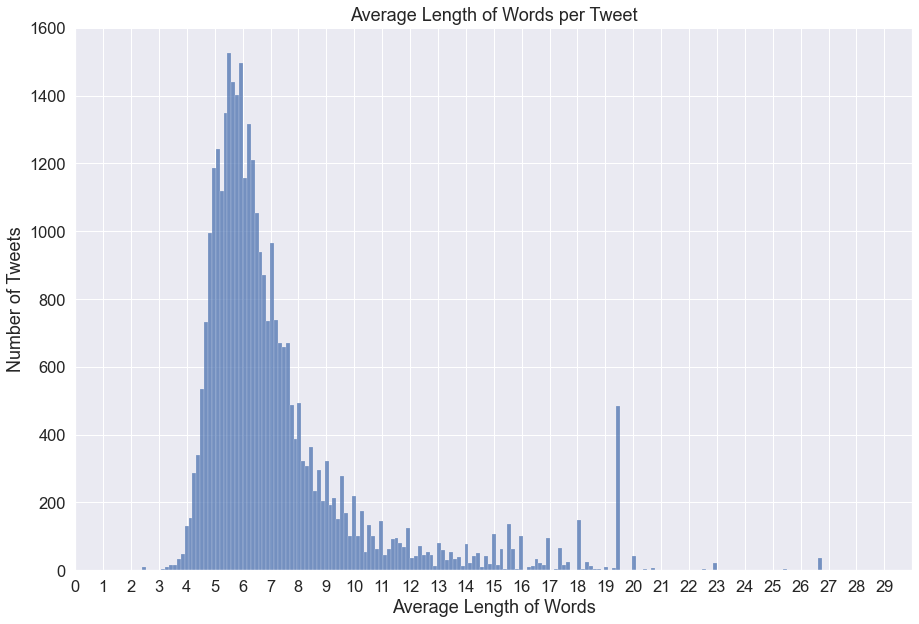

In [156]:
# let's check what is the average word length per tweet
sns.histplot(df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)))
plt.xticks(list(range(0, 30, 1)))
plt.xlim(0, 30)
plt.xlabel('Average Length of Words')
plt.ylabel('Number of Tweets')
plt.title('Average Length of Words per Tweet');

###### We can observe that average length of the words per tweet is around 6 chars, which I think is normal. However, we do have some extreme outliers on the right that we should look into. Big number of mentions is probably what is causing such behaviour.